# Example code reading swissfel data

## Standard Bernina environment

If using the bernina conda activate in Terminal with
```bash
source /sf/bernina/bin/anaconda_env
```
If you like to use the bernina conda envs in jupytera (jupyterhub of ra) you'll need to add a .condarc file in your home folder with content
```
envs_dirs:
  - /sf/bernina/anaconda
```
e.g. by this command line:
```bash
printf "%s\n%s\n" "envs_dirs:" "  - /sf/bernina/anaconda" >> ~/.condarc
```
## Reading data using ```escape``` parser

Importing some usual and useful tools, as well as a file parser for the scan json files:

In [1]:
%matplotlib notebook
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from escape.parse import swissfel


Using the swissfel parser from escape to look for datasets in the hdf5 files and create h5py array links to each relevant dataset in the data. By default this infomration is output as a ```escape.Array``` an object using dask arrays as pointer to the data from all scan steps.

The createEscArrays keyword set to False allows to retrieve h5py handles instead of escape arrays. 
The memlimit_mD_MB is the chunk size limit for large datasets as the JF7 (16Mpix), which needs to be a bit larger than the default.

In [2]:
data = swissfel.parseScanEco_v01('/sf/bernina/data/p17743/res/scan_info/run0000_test01.json',
                                 createEscArrays=True, 
                                 memlimit_mD_MB=50)

Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch3-TIME-AXIS in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch2-DATA-AMP in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch1-DATA-AMP in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch1-TIME-AXIS in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch4-TIME-AXIS in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch2-TIME-AXIS in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch4-DATA-AMP in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch3-DATA-AMP in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch4-DATA-AMP in cycle 1
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch1-TIME-A

Some examples of the escape Array properties:

In [3]:
jf7 = data['JF07T32V01']
print(f'The shape of all JF7 data in scan is {jf7.data.shape}.')
print(f'Those are data from {jf7.data.shape[jf7.eventDim]} events.')
print(f'Inside the escape array the field \'data\' is an instance of  {type(jf7.data)}.')

The shape of all JF7 data in scan is (1100, 16384, 1024).
Those are data from 1100 events.
Inside the escape array the field 'data' is an instance of  <class 'dask.array.core.Array'>.


In [13]:
evcode = data['SAR-CVME-TIFALL5:EvtSet']
laser_on = evcode.data[:,20].compute()
print(laser_on)

[1 0 1 ..., 1 0 1]


## Correct Jungfrau data for gains and pedestals

In [4]:
import h5py
from jungfrau_utils import apply_gain_pede, apply_geometry
h5py.enable_ipython_completer()

Read gain map and pedestal file

In [5]:
with h5py.File('/sf/bernina/config/jungfrau/gainMaps/JF07T32V01/gains.h5','r') as f:
    gains = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/JF_pedestals/pedestal_20190115_1551.JF07T32V01.res.h5','r') as f:
    pede = f['gains'].value
    noise = f['gainsRMS'].value
    mask = f['pixel_mask'].value

<IPython.core.display.Javascript object>


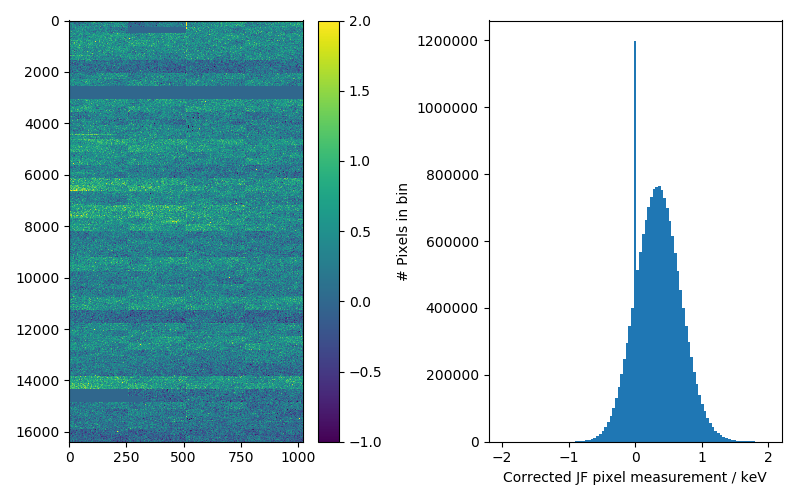

In [6]:
icorr = apply_gain_pede(jf7.data[0].compute(),G=gains, P=pede, pixel_mask=mask)


# plot example
f,axs = plt.subplots(1,2,num='Jungfrau correction example',figsize=[8,5])
icorr_h = axs[0].imshow(icorr,aspect='auto',clim=[-1,2]) # raw data (16384, 1024)
plt.colorbar(icorr_h,ax=axs[0])
dum = axs[1].hist(icorr.ravel(),np.linspace(-2,2,100))
axs[1].set_xlabel('Corrected JF pixel measurement / keV')
axs[1].set_ylabel('# Pixels in bin')
plt.tight_layout()

Pedestal seems a bit old for recorded data, as not centered at exactly zero. Bernina usually applies some common mode correction to fix that. 

## Geomtrical assembly of a full pattern 
We have presently only code to do a simple geometrical correction, essentially only placing the data into a larger pattern, no tile rotations and no fractional shifts taken into account. 

<IPython.core.display.Javascript object>


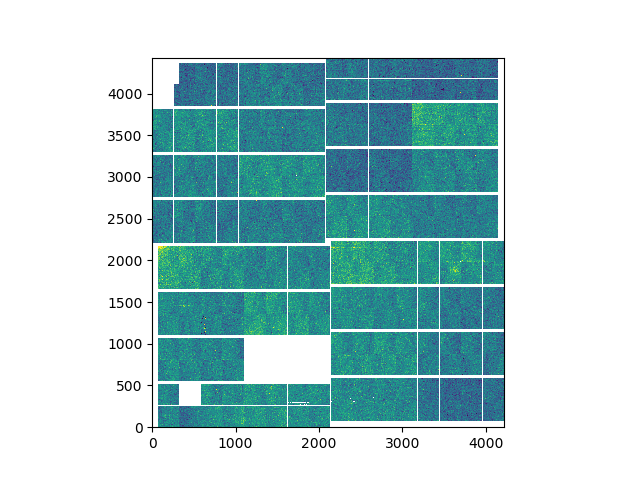

In [7]:
icorr_geom = apply_geometry(icorr,'JF07T32V01')

mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')

icorr_geom_mask = icorr_geom
icorr_geom_mask[mask_geom] = np.nan

f = plt.figure('geometry correction')
f.clf()
ah = f.add_subplot(1,1,1)
ah.imshow(icorr_geom_mask,clim=[-1,2],origin='lower')




In [8]:
print(icorr.shape)
print(icorr_geom.shape)
print(jf7)

(16384, 1024)
(4432, 4215)
<escape.storage.Array object at 0x2b31b29225f8> None; shape (1100, 16384, 1024)
Scan over 11 steps
Parameters eos_delay, eos_delay_readback
